In [1]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [3]:
num_classes = 100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

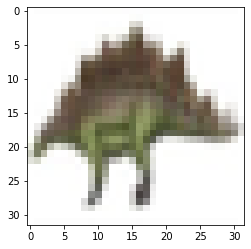

In [4]:
plt.imshow(x_train[1])

In [5]:
#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


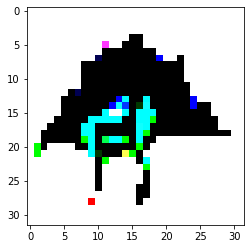

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_train[1])

In [7]:
# one-hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [8]:
x_val = x_train[40000:50000, ]
x_train = x_train[:40000, ]
y_val = y_train[40000:50000]
y_train = y_train[:40000]
print(x_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 100)


In [9]:
size = (224, 224)

x_train = x_train.map(lambda x, y: (tf.image.resize(x, size), y))
x_val = x_val.map(lambda x, y: (tf.image.resize(x, size), y))
x_test = x_test.map(lambda x, y: (tf.image.resize(x, size), y))

AttributeError: ignored

In [9]:
data_gen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
data_gen.fit(x_train)
val_gen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
val_gen.fit(x_val)

In [10]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
t=time.time()
bt_size = 64
Epoch = 6
historytemp = model.fit_generator(data_gen.flow(x_train, y_train,
                                  batch_size=bt_size),
                                  steps_per_epoch=x_train.shape[0] // bt_size,
                                  epochs=Epoch,
                                  validation_data=(val_gen.flow(x_val, y_val, batch_size=bt_size)), validation_steps=x_val.shape[0]//bt_size)
print('Training time: %s' % (time.time() - t))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
  1/625 [..............................] - ETA: 8:59:54 - loss: 5.2925 - accuracy: 0.0156

KeyboardInterrupt: ignored

In [ ]:
# unfreeze weights
for layer in resnet_model.layers:
    layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min',
                   patience = 10, restore_best_weights = True, verbose = 1)

In [ ]:
hist = model.fit_generator(data_gen.flow(x_train, y_train,
                                  batch_size=bt_size),
                                  steps_per_epoch=x_train.shape[0] // bt_size,
                                  epochs=30, verbose=1, callbacks=[es],
                                  validation_data=(val_gen.flow(x_val, y_val, batch_size=bt_size)),
                           validation_steps=x_val.shape[0]//bt_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
469/625 [=====================>........] - ETA: 4:02 - loss: 3.3619 - accuracy: 0.2630

In [ ]:
model.save_weight('best_w.h5')